# PINN codes for Navier stokes and the heat equation

Prathvik G S

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl 
import random

print(tf.__version__)

2.11.0


# Advection equation
$$\frac{\partial{u}}{\partial{t}}+v\frac{\partial{u}}{\partial{x}}=0$$
$$u(x,0)=e^{-x^2}$$


# The architecture

In [48]:
tf.keras.backend.set_floatx('float32')

#Define the neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(40, activation='tanh', input_shape=(2,)),
    tf.keras.layers.Dense(40, activation='tanh'),
     tf.keras.layers.Dense(40, activation='tanh'),
    tf.keras.layers.Dense(40, activation='tanh'),
    tf.keras.layers.Dense(1)
])

# Custom loss function describing the Navier stokes eqn with boundary conditions and incompressibility

In [49]:
#loss function for the PINN

v=0.5

def loss(x_pde,x_ini):
    
    with tf.GradientTape(persistent=True) as tape:
        #loss from the PDE
        x,t=tf.unstack(x_pde,axis=1)
        tape.watch(x)
        tape.watch(t)
        
        u_pred=model(tf.stack((x,t),axis=1))
        
        dudx=tape.gradient(u_pred,x)
        dudt=tape.gradient(u_pred,t)
        
        loss = tf.reduce_mean(tf.square(dudt+v*dudx))
    
        #initial loss
        xi,ti=tf.unstack(x_ini,axis=1)
        ui = model(tf.stack((xi,ti),axis=1))
        
        lossb=tf.reduce_mean(tf.square(ui-u_ini))    
        
    return loss + lossb 

In [50]:
# Define the grid size
N = 40
x_0=-1
x_L=1
t_0=0
t_L=1

# Define the coordinates of the grid points
x = np.linspace(x_0, x_L, N)
t = np.linspace(t_0, t_L, N)

nx, nt = np.meshgrid(x, t, indexing='ij')
nx1=np.reshape(nx,-1)
nt1=np.reshape(nt,-1)
#nx=2*np.random.rand(100000,1)-1
#ny=2*np.random.rand(100000,1)-1
nxnt = np.concatenate([nx1[:, None], nt1[:, None]], axis=1)
x_pde=tf.convert_to_tensor(nxnt, dtype=tf.float32, dtype_hint=None, name=None)

In [51]:
def g(x,t):
    return np.e**(-(x-v*t)**2)

In [52]:
'initial'
xi = np.linspace(x_0, x_L, 30)
ti = np.zeros((30,1))
nx, ny = np.meshgrid(xi, ti, indexing='ij')
nx1=np.reshape(nx,-1)
ny1=np.reshape(ny,-1)
x_ini = np.concatenate([nx1[:, None], ny1[:, None]], axis=1)

u_ini=g(x_ini[:,0],x_ini[:,1])

In [57]:
# Define the optimizer
optimizer = tf.keras.optimizers.Adam()

# Train the model
for epoch in range(1000):
    with tf.GradientTape() as tape:
        loss_value = loss(x_pde,x_ini)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    if epoch % 1 == 0:
        #print(f"Epoch {epoch}, loss={loss_value:.6f}")
        print("epoch {}/{}, loss={:.10f}".format(epoch+1,1000,  loss_value), end="\r")

In [54]:
# Define the coordinates of the grid points
x = np.linspace(x_0, x_L, 30)
y = np.linspace(t_0, t_L,30)

nx, ny = np.meshgrid(x, y, indexing='ij')
nx, ny = np.meshgrid(x, y, indexing='ij')
nx1=np.reshape(nx,-1)
ny1=np.reshape(ny,-1)
nxny = np.concatenate([nx1[:, None], ny1[:, None]], axis=1)

u=model(nxny)

# PINN model solution

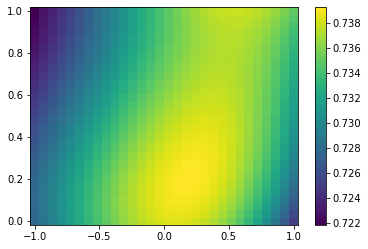

In [55]:
u=tf.reshape(u,(30,30))
fig, ax = plt.subplots(1, 1)
c=plt.pcolormesh(nx,ny,u)
plt.colorbar()
plt.show()

# Analytical pressure

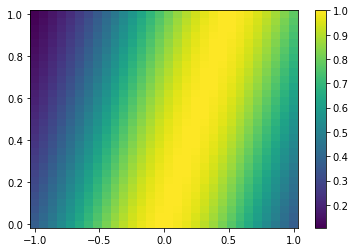

In [56]:
p_t=g  (nxny[:,0],nxny[:,1])

p_t=tf.reshape(p_t,(30,30),tf.float32)
fig, ax = plt.subplots(1, 1)
c=plt.pcolormesh(nx,ny, p_t)
plt.colorbar()
plt.show()